In [1]:
import os
!sudo apt-get update -qq > /dev/null   
# Install java
!sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install -f nlu pyspark==2.4.7 > /dev/null

In [77]:
import pandas as pd
import numpy as np
import tqdm
import re
import json
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import nlu
import threading

In [73]:
# embeddings = [predictions[predictions['description'] == df.description[i]] for i in df.index]
def clear_memory():
    gc.collect()
    os.system('sudo sysctl -w vm.drop_caches=3')
    
clear_memory()

In [3]:
df = pd.read_feather('sampleindex/sample100000.ftr')

In [4]:
df = df[['text_reviews_count', 'country_code', 'language_code', 'average_rating', 'description', 'link','num_pages', 'url','image_url',
               'book_id', 'ratings_count', 'title', 'title_without_series']]

In [5]:
df.head()

,text_reviews_count,country_code,language_code,average_rating,description,link,num_pages,url,image_url,book_id,ratings_count,title,title_without_series
0,1,US,,4.00,,https://www.goodreads.com/book/show/5333265-w-...,256,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,6,US,,3.23,"Anita Diamant's international bestseller ""The ...",https://www.goodreads.com/book/show/1333909.Go...,,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10,Good Harbor,Good Harbor
2,7,US,eng,4.03,Omnibus book club edition containing the Ladie...,https://www.goodreads.com/book/show/7327624-th...,600,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,3282,US,eng,3.49,Addie Downs and Valerie Adler were eight when ...,https://www.goodreads.com/book/show/6066819-be...,368,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184,Best Friends Forever,Best Friends Forever
4,5,US,,3.40,,https://www.goodreads.com/book/show/287140.Run...,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...


In [6]:
df['desclen'] = df.description.apply(lambda x: len(x.split()))

In [11]:
max(df.desclen.value_counts())
# i.e there are 17304 books without descriptions, we will use their title where they dont have descriptions

17304

In [16]:
newdescription = [df.description[x] if len(df.description[x].split())>1 else df.title[x] for x in df.index]

In [17]:
df.description = newdescription
df['desclen'] = df.description.apply(lambda x: len(x.split()))
max(df.desclen.value_counts())

2517

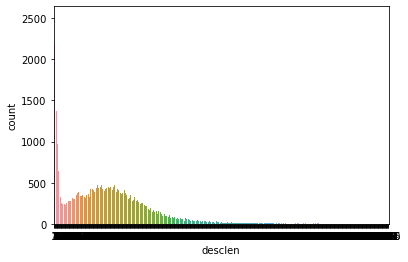

In [41]:
sns.countplot(x=df.desclen)

In [52]:
def clear_text(sentence):
    sentence = re.sub(r'[^\x00-\x7f]', '', sentence, re.I)
    sentence = re.sub(r'\n', '', sentence, re.I)
    sentence = re.sub(r'\\n', '', sentence, re.I)
    sentence = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', sentence, re.I)
    sentence = re.sub('(\s|\t){2,3}', '\s', sentence, re.I)
    sentence = re.sub(r'@|\\', '', sentence, re.I)
    sentence = re.sub(r"[()\"#/@;:<>{}=~|?\'\`]", "", sentence)
    return sentence

In [59]:
df.description = df.description.apply(lambda x : clear_text(x))

In [60]:
df['desclen'] = df.description.apply(lambda x: len(x.split()))
max(df.desclen.value_counts())

2500

In [71]:
pipe = nlu.load('embed_sentence.bert')

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [72]:
predictions = pipe.predict(df.description, output_level='document', drop_irrelevant_cols=True, verbose=1)

In [74]:
predictions.head()

,description,text,embed_sentence_bert_embeddings,document
origin_index,,,,
0,W.C. Fields A Life on Film,W.C. Fields A Life on Film,"[-0.829294741153717, 0.30839240550994873, -0.5...",W.C. Fields A Life on Film
1,Anita Diamants international bestseller The Re...,Anita Diamants international bestseller The Re...,"[-0.5028615593910217, 0.1767210215330124, -0.5...",Anita Diamants international bestseller The Re...
2,Omnibus book club edition containing the Ladie...,Omnibus book club edition containing the Ladie...,"[-1.1011953353881836, 0.1527175009250641, 0.28...",Omnibus book club edition containing the Ladie...
3,Addie Downs and Valerie Adler were eight when ...,Addie Downs and Valerie Adler were eight when ...,"[-0.5350350141525269, -0.1772732138633728, -0....",Addie Downs and Valerie Adler were eight when ...
4,Runic Astrology Starcraft and Timekeeping in t...,Runic Astrology Starcraft and Timekeeping in t...,"[-1.0804023742675781, -0.5806970000267029, -0....",Runic Astrology Starcraft and Timekeeping in t...


In [75]:
# mutithreading version
def func_thread(description, res, index):
    embeddingsres = predictions[predictions['description'] == description]
    res[index] = embeddingsres

In [78]:
thread_list = []
embeddings = {}

breakctr = 0
for i in df.index:
    thread = threading.Thread(target=func_thread, args=(df.description[i], embeddings, i))
    thread_list.append(thread)
    
for thread in thread_list:
    thread.start()
for thread in thread_list:
    thread.join()

In [79]:
embeddings_list = [embeddings[i]['embed_sentence_bert_embeddings'] for i in df.index]
df['embeddings'] = embeddings_list

In [84]:
df.columns 

Index(['text_reviews_count', 'country_code', 'language_code', 'average_rating',
       'description', 'link', 'num_pages', 'url', 'image_url', 'book_id',
       'ratings_count', 'title', 'title_without_series', 'desclen',
       'embeddings'],
      dtype='object')

In [86]:
df.drop(['text_reviews_count','title_without_series', 'desclen'], axis=1, inplace=True)

[Text(0, 0, ''),
 Text(0, 0, 'eng'),
 Text(0, 0, 'ger'),
 Text(0, 0, 'spa'),
 Text(0, 0, 'en-US'),
 Text(0, 0, 'ita'),
 Text(0, 0, 'per'),
 Text(0, 0, 'en-GB'),
 Text(0, 0, 'tur'),
 Text(0, 0, 'ind'),
 Text(0, 0, 'mon'),
 Text(0, 0, 'fre'),
 Text(0, 0, 'por'),
 Text(0, 0, 'ara'),
 Text(0, 0, 'en-CA'),
 Text(0, 0, 'tha'),
 Text(0, 0, 'lav'),
 Text(0, 0, 'jpn'),
 Text(0, 0, 'pol'),
 Text(0, 0, 'swe'),
 Text(0, 0, 'kor'),
 Text(0, 0, 'fin'),
 Text(0, 0, 'msa'),
 Text(0, 0, 'bul'),
 Text(0, 0, 'nl'),
 Text(0, 0, 'gre'),
 Text(0, 0, 'slo'),
 Text(0, 0, 'nor'),
 Text(0, 0, 'heb'),
 Text(0, 0, 'hun'),
 Text(0, 0, 'ben'),
 Text(0, 0, 'scr'),
 Text(0, 0, 'zho'),
 Text(0, 0, 'fil'),
 Text(0, 0, 'rus'),
 Text(0, 0, 'lit'),
 Text(0, 0, 'rum'),
 Text(0, 0, 'cze'),
 Text(0, 0, 'dan'),
 Text(0, 0, 'slv'),
 Text(0, 0, 'nno'),
 Text(0, 0, 'pes'),
 Text(0, 0, 'hye'),
 Text(0, 0, 'nob'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'en'),
 Text(0, 0, 'vie'),
 Text(0, 0, 'nep'),
 Text(0, 0, 'mar'),
 Text(0, 0, 'srp'),

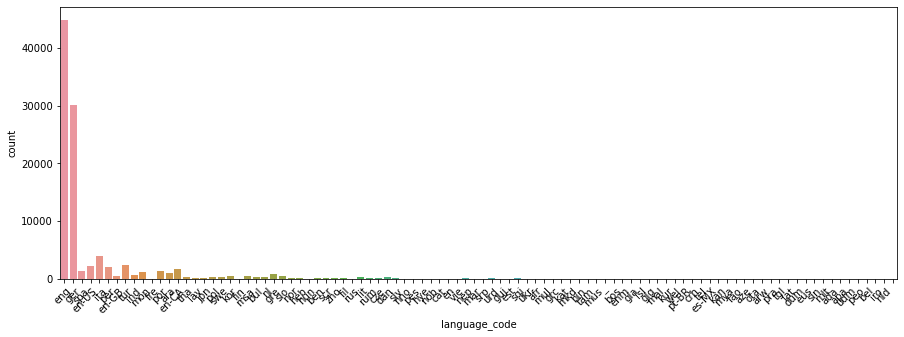

In [108]:
plt.figure(figsize=(15,5))
chart = sns.countplot(x = df.language_code)
chart.set_xticklabels(labels = chart.get_xticklabels() , rotation=45, horizontalalignment='right')

In [114]:
df.to_pickle('embeddings_sample1.pkl')